In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/CODSOFT /Titanic-Dataset.csv')

In [3]:
# Exploratory Data Analysis (EDA)
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe(include='all'))

Dataset shape: (891, 12)

First few rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0     

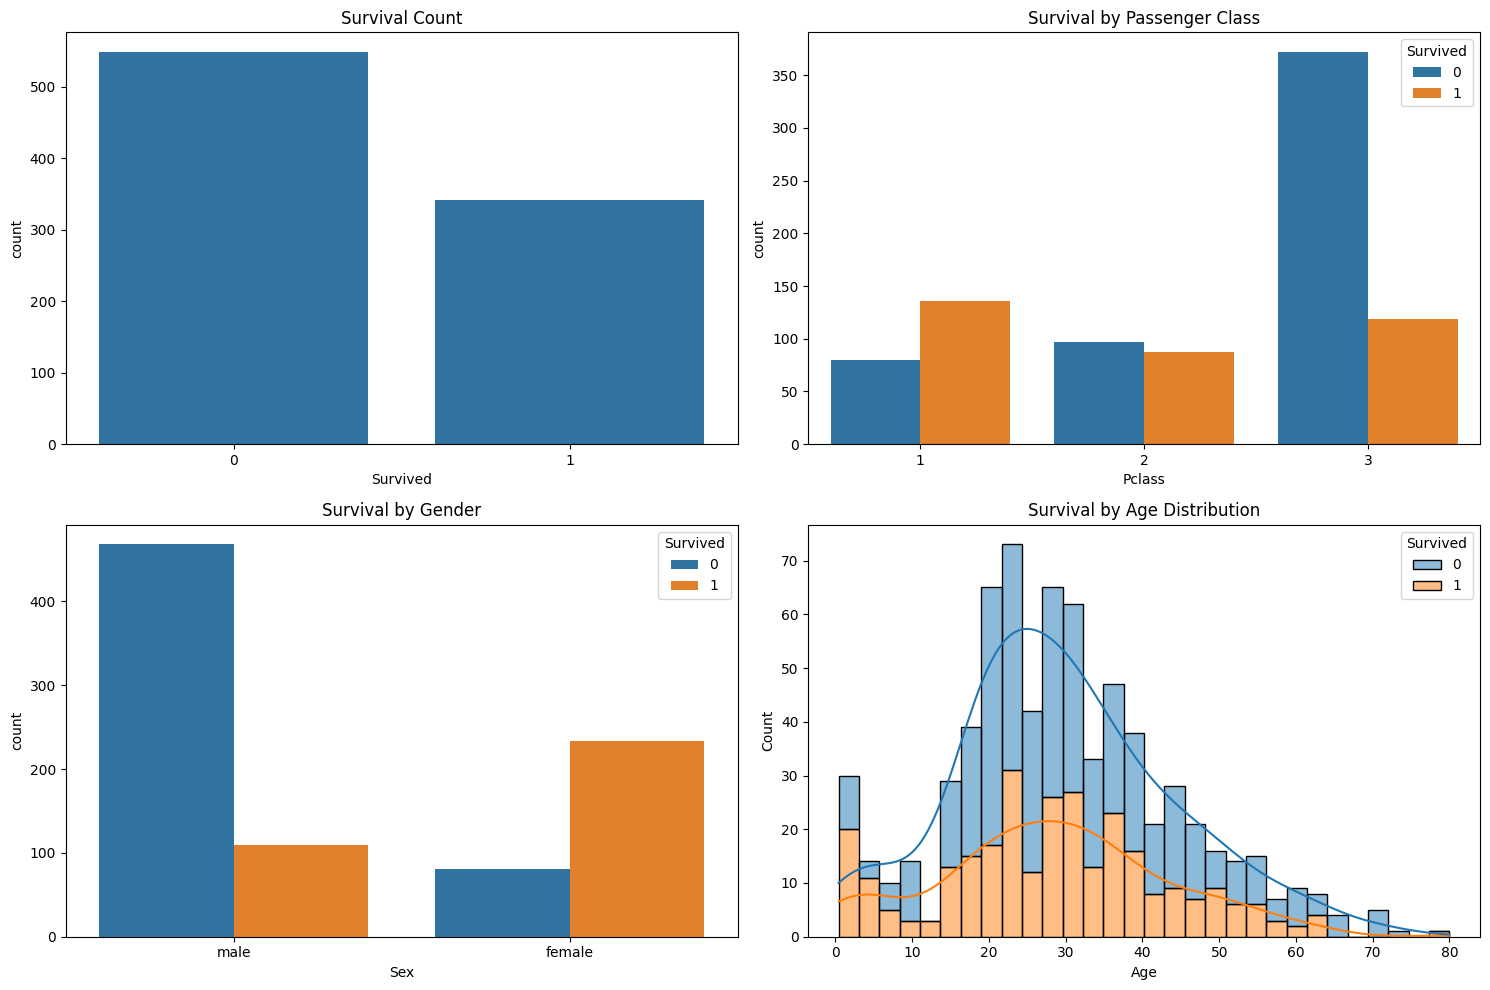

In [4]:
# Visualizations
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='Survived', data=df)
plt.title('Survival Count')

plt.subplot(2, 2, 2)
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival by Passenger Class')

plt.subplot(2, 2, 3)
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Survival by Gender')

plt.subplot(2, 2, 4)
sns.histplot(data=df, x='Age', hue='Survived', bins=30, kde=True, multiple='stack')
plt.title('Survival by Age Distribution')

plt.tight_layout()
plt.show()

In [5]:
# Feature Engineering
# Extracting the title from names
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',
                                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [6]:
# Creating family size feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

In [7]:
# Create age bands
df['AgeBand'] = pd.cut(df['Age'], 5)
df.loc[df['Age'] <= 16, 'Age'] = 0
df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
df.loc[df['Age'] > 64, 'Age'] = 4

In [8]:
# Create fare bands
df['FareBand'] = pd.qcut(df['Fare'], 4)
df.loc[df['Fare'] <= 7.91, 'Fare'] = 0
df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare'] = 2
df.loc[df['Fare'] > 31, 'Fare'] = 3

In [9]:
# Drop unnecessary columns
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'AgeBand', 'FareBand'], axis=1)

In [10]:
# Split data into features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Define preprocessing steps
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [13]:
# Create and train the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', RandomForestClassifier(random_state=42))])

In [15]:
# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.827


In [16]:
# Make predictions
y_pred = best_model.predict(X_test)

In [17]:
# Evaluate the model
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Model Evaluation:
Accuracy: 0.827

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179


Confusion Matrix:
[[97 13]
 [18 51]]
